In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks,lombscargle
from keras import backend as K
import GetLightcurves as gc
import os

In [2]:
#read reshape normalize input data
Xtrain, Ytrain, Ltrain, TrainID = gc.read_tfr_record('../../training_data/cumulative_train',
    ['input','map','label','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.bool, tf.string])

Xval, Yval, Lval, ValID = gc.read_tfr_record('../../training_data/cumulative_val',
    ['input','map','label','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.bool, tf.string])

Xtest, Ytest, Ltest, TestID = gc.read_tfr_record('../../training_data/cumulative_test',
    ['input','map','label','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.bool, tf.string])

Ytrain=np.asarray(Ytrain).reshape(len(Xtrain),4000,3)
Yval=np.asarray(Yval).reshape(len(Xval),4000,3)
Ytest=np.asarray(Ytest).reshape(len(Xtest),4000,3)
print(Ytrain.shape, Ytest.shape)

Xtrainf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtestf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
Xvalf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xval])

TrainID = [str(TrainID[i])[2:11] for i in range(0,len(TrainID))]
TestID = [str(TestID[i])[2:11] for i in range(0,len(TestID))]
ValID = [str(ValID[i])[2:11] for i in range(0,len(ValID))]

(8048, 4000, 3) (1005, 4000, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

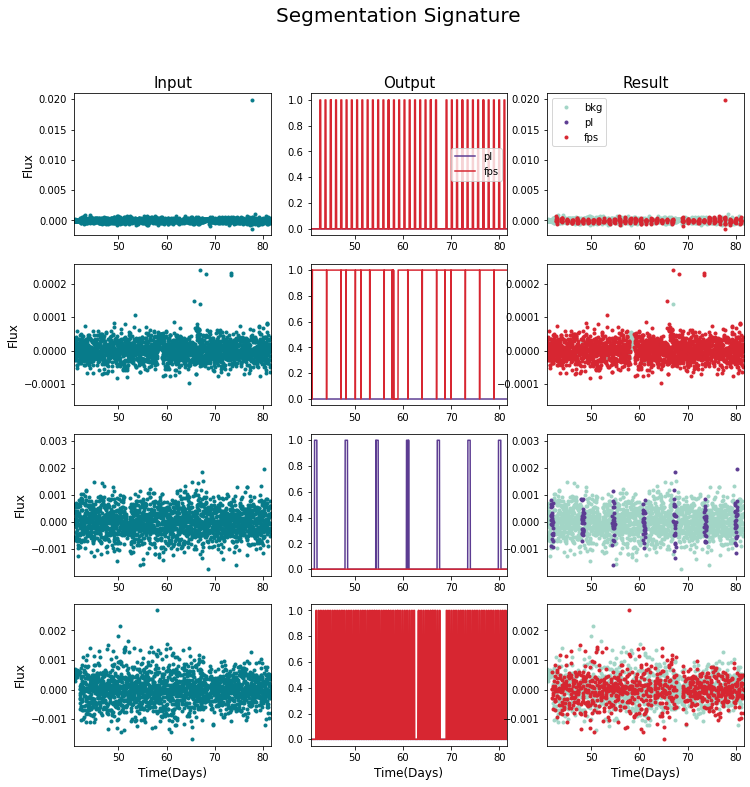

In [3]:
#plot the training maps and all

Ytrain = np.asarray(Ytrain, dtype = 'float32')
Ytest = np.asarray(Ytest, dtype = 'float32')
vararr=np.random.randint(0,len(Xtrain),size=10)
vararr=[5,247,3,375]
#vararr=[375,376,396,442,456,613]
fig,ax=plt.subplots(4,3,figsize=(12,12))
j=0

xaxis = np.arange(0,4000,1)*29.5/1440
plt.suptitle('Segmentation Signature',size=20)
ax[0][0].set_title('Input',size=15)
ax[0][1].set_title('Output',size=15)
ax[0][2].set_title('Result',size=15)

ax[3][0].set_xlabel('Time(Days)',size=12)
ax[3][1].set_xlabel('Time(Days)',size=12)
ax[3][2].set_xlabel('Time(Days)',size=12)
for i in range(0,4):
    ax[i][0].plot(np.arange(0,4000,1)*29.4/1440,Xtrain[vararr[i]],color='#077b8a',marker='.',ls='None')
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in Ytrain[vararr[i]]])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    #predpl = np.where(Ytest[ar[i],:,0]==1)[0]
    bkg=np.where(counts==2)[0]
    ax[i][0].set_ylabel('Flux',size=12)
    ax[i][2].plot(bkg*29.4/1440,Xtrain[vararr[i]][bkg],marker='.',ls='None',color='#a2d5c6',label='bkg')
    ax[i][2].plot(pl*29.4/1440,Xtrain[vararr[i]][pl],marker='.',ls='None',color='#5c3c92',label='pl')
    ax[i][2].plot(fps*29.4/1440,Xtrain[vararr[i]][fps],marker='.',ls='None',color='#d72631',label='fps')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,0],color='#5c3c92',label='pl')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,1],color='#d72631',label='fps')
    ax[0][1].legend()
    ax[0][2].legend()
    ax[i][2].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][1].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][0].set_xlim(2000*29.4/1440,4000*29.4/1440)
#plt.savefig('fprez_segmentation2')
plt.show

In [4]:
#loss functions defined

def dice_coeff(y_true, y_pred):
    smooth = 0.00001
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection +smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) +smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def weightFocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA): 
    w = tf.reduce_sum(targets,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 - w
    #w = 1 / (w  + 0.00001)
    #w = w**2
    w=tf.cast(w,tf.float32)   
    
    #inputs = K.flatten(inputs)
    #targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(w*K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    #w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def generalized_dice_coeff_v2(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w**2  + 0.00001)

    z=tf.slice(w,[0],[2])
    z2 = tf.slice(w,[2],[1])
    z=tf.reduce_mean(z)
    z2=tf.reduce_mean(z2)
    w =  tf.stack([z,z*0.7,z2])

    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def focal_dice_loss(y_true, y_pred):
    loss = FocalLoss(y_true, y_pred) + 1*log_cosh_dice_loss(y_true, y_pred)
    return loss

In [17]:
def corr(y_true, y_pred):
    #wholesome thing.... lets see if this is any better
    corrects = 0 
    incorrects = 0
    cm=[[0,0],[0,0]]
    pred_arr=[]
    for i in range(0, len(y_true)):
        tmp=[0,0]
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        #newpl=np.asarray([1 if(el>np.mean(newpl)+np.std(newpl)) else 0 for el in newpl])
        #newfps=np.asarray([1 if(el>np.mean(newfps)+np.std(newfps)) else 0 for el in newfps])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]): 
                corrects+=1
                cm[0][0]+=1
                tmp[0]=1
            else: 
                incorrects+=1
                cm[1][0]+=1
                tmp[1]=1
            #print(val1[0,1], val2[0,1])
        #fps detect
        if(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                corrects+=1
                cm[1][1]+=1
                tmp[1]=1
            else: 
                cm[0][1]+=1
                incorrects+=1
                tmp[0]=1
            #print(val1[0,1], val2[0,1])
        pred_arr.append(tmp)
        #planet detection:
    
    print(corrects, incorrects)
    print(np.asarray(cm)/np.asarray(cm).sum())
    print(corrects/(corrects+incorrects))

def corr_v2(l_true, y_pred, y_true):
    cm=np.array([[0,0],[0,0]])
    arr =[]
    for i in range(0, len(y_true)):
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        plorno=[0,0]

        if(np.any(y_true[i,:,0]>0)): 
            plorno[0] = 1
            corrpl1 = np.corrcoef(newpl, y_true[i,:,0])[0,1]
            corrfps1 = np.corrcoef(newfps, y_true[i,:,0])[0,1]
        else: corrpl1= corrfps1 = 0

        if(np.any(y_true[i,:,1]>0)): 
            plorno[1] = 1
            corrfps2 = np.corrcoef(newfps, y_true[i,:,1])[0,1]
            corrpl2 = np.corrcoef(newpl, y_true[i,:,1])[0,1]
        else: corrfps2 = corrpl2 = 0

        if(np.all(np.array(plorno)==1)): 
            print("mult")
            #if(corrpl1>corrfps2): cm[0,0]+=1
            #else: cm[1,1]+=1
            if(l_true[i][0]==1): 
                arr.append(0)
                cm[0,0]+=1
            else: 
                arr.append(1)
                cm[1,1]+=1
            continue
        if(corrfps2>corrpl2 and plorno[1] == 1):
            arr.append(1)
            cm[1,1]+=1
        elif(corrfps1<corrpl1 and plorno[0] == 1): 
            arr.append(0)
            cm[0,0]+=1
        elif(corrfps1>corrpl1 and plorno[0]==1): 
            arr.append(1)
            cm[0,1]+=1
        elif(corrfps2<corrpl2 and plorno[1]==1): 
            arr.append(0)
            cm[1,0]+=1

    print(np.asarray(cm)/np.asarray(cm).sum())
    return(np.asarray(arr))



def corrarr(y_true, y_pred):
    checkarr=[]
    labarr=[]
    for i in range(0, len(y_true)):
        labvalpl = 0
        labvalfps = 0
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]):
                checkarr.append(0)
            else: 
                checkarr.append(1)
            labvalpl = val2[0,1]
            #print(val1[0,1], val2[0,1])
        #fps detect
        if(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                checkarr.append(0)
            else: 
                checkarr.append(1)
            labvalfps = val1[0,1]
        if(labvalfps>labvalpl): labarr.append(1)
        else: labarr.append(0)
    return(checkarr,labarr)

In [7]:
IMG_SIZE=4000
def build_model_unpad(imsz):
    conv_ip = keras.layers.Input(shape=(imsz,),name='Input')
    xi=keras.layers.Reshape((imsz, 1), input_shape=(imsz,),name='reshape_1')(conv_ip)
    #xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
    xi=keras.layers.BatchNormalization()(xi)

    x1=keras.layers.SeparableConv1D(16,kernel_size=3,activation='relu',name='1st16_5')(xi)  #3998, 32
    c1=keras.layers.SeparableConv1D(16,kernel_size=3,strides=1,activation='relu',name='2nd16_3')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1')(x2)  #1998, 64
    #x2=keras.layers.Conv1D(16,kernel_size=1,strides=2,name='maxpool_1')(x2)  #1998, 64
    x2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='relu',name='1st32_5')(x2) #1996, 64
    c2=keras.layers.SeparableConv1D(32,kernel_size=5,strides=1,activation='relu',name='2nd32_3')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2')(x3)  #996, 64
    #x3=keras.layers.Conv1D(32,kernel_size=1,strides=2,name='maxpool_2')(x3)  #996, 64
    x3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='relu',name='1st64_5')(x3) #994, 128
    c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='relu',name='2nd64_3')(x3) #992, 128

    x4=keras.layers.BatchNormalization(name='bn3')(c3)
    x4=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_3')(x4)  #496, 64
    #x4=keras.layers.Conv1D(64,kernel_size=1,strides=2,name='maxpool_3')(x4)  #496, 128
    x4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='relu',name='1st128_5')(x4)  #494, 256
    c4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='relu',name='2nd128_5')(x4) #492, 256


    x5=keras.layers.BatchNormalization(name='bn4')(c4) 
    x5=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_4')(x5) #246, 256 
    #x5=keras.layers.Conv1D(128,kernel_size=1,strides=2,name='maxpool_4')(x5)  #246, 256  
    x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='relu',name='1st512_5')(x5)  #244, 256
    x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='relu',name='2nd512_5')(x5)  #242, 256

    x5 = keras.layers.Conv1DTranspose(128, kernel_size=4, activation='relu', strides=2, name="T1st128_5")(x5)  #486, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', strides=1, name="T2nd128_5")(x5)  #490, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T3rd128_5")(x5)  #492, 256
    x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

    #c4 = keras.layers.Cropping1D((2,2))(c4) #488, 256
    x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
    x6 = keras.layers.Conv1DTranspose(128,kernel_size=3,strides=1,activation='relu',name='3rd128_3')(x6) #494, 256
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=4, activation='relu', strides=2, name="T1st64_3")(x6) #990, 128
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=1, name="T2nd64_3")(x6) #992, 128
    x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

    #c3 = keras.layers.Cropping1D((4,4))(c3) #984, 128
    x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
    x7 = keras.layers.Conv1DTranspose(64,kernel_size=3,strides=1,activation='relu',name='3rd64_3')(x7) #994, 128
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=4, activation='relu', strides=2, name="T1st32_3")(x7) #1990, 64
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', strides=1, name="T2nd32_3")(x7) #1992, 64
    x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

    x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
    x8 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=1,activation='relu',name='3rd32_3')(x8)  #1994, 64
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=4,strides=2,activation='relu',name='T1st16_3')(x8) #3990, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T2nd16_3')(x8) #3994, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='T4rth16_3')(x8) #3996, 32
    x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

    #c1 = keras.layers.Cropping1D((1,1))(c1) #3994, 32
    x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='3rd16_3')(x9) #3998, 32
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T3rd16_3')(x9) #4002, 32
    x9 = keras.layers.BatchNormalization(name='bn9')(x9)

    conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,name='semiop',activation='softmax')(x9) # (4000, 3)

    keras.backend.clear_session()
    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=focal_dice_loss ,metrics=[dice_coeff] )
    return(convNN)

def build_model_pad(imsz):
    conv_ip = keras.layers.Input(shape=(imsz,),name='Input')
    xi=keras.layers.Reshape((imsz, 1), input_shape=(imsz,),name='reshape_1')(conv_ip)

    x1=keras.layers.Conv1D(16,kernel_size=10,dilation_rate=3,activation='tanh',name='1st16_5', padding='same')(xi)  #3998, 32
    c1=keras.layers.Conv1D(16,kernel_size=5,activation='tanh',name='2nd16_3', padding='same')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1', padding='same')(x2)  #1998, 64
    x2=keras.layers.Conv1D(32,kernel_size=5,dilation_rate=2,strides=1,activation='tanh',name='1st32_5', padding='same')(x2) #1996, 64
    c2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',name='2nd32_3', padding='same')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2', padding='same')(x3)  #996, 64
    x3=keras.layers.Conv1D(64,kernel_size=5,dilation_rate=2,strides=1,activation='tanh',name='1st64_5', padding='same')(x3) #994, 128
    c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='2nd64_3', padding='same')(x3) #992, 128

    x4=keras.layers.BatchNormalization(name='bn3')(c3)
    x4=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_3', padding='same')(x4)  #496, 64
    x4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='1st128_5', padding='same')(x4)  #494, 256
    c4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='2nd128_5', padding='same')(x4) #492, 256

    x_5=keras.layers.BatchNormalization(name='bn4')(c4) 
    x_5=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_4', padding='same')(x_5) #246, 256 
    x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='1st512_5', padding='same')(x_5)  #244, 256
    x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='2nd512_5', padding='same')(x_5)  #242, 256
    #x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='3rd512_5', padding='same')(x_5)  #242, 256

    #tdepth, snr
    extra_ip = keras.layers.Input(shape=(2,),name='Input2')
    xi2=keras.layers.RepeatVector(250)(extra_ip)
    xi2 = keras.layers.Conv1D(256, 3, padding='same')(xi2)
    x5 = keras.layers.Multiply()([xi2, x_5])

    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=2, name="T1st128_5", padding='same')(x5)  #486, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T2nd128_5", padding='same')(x5)  #490, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T3rd128_5", padding='same')(x5)  #492, 256
    x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

    x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
    x6 = keras.layers.Conv1DTranspose(128,kernel_size=3,strides=1,activation='relu',name='3rd128_3', padding='same')(x6) #494, 256
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=2, name="T1st64_3", padding='same')(x6) #990, 128
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=1, name="T2nd64_3", padding='same')(x6) #992, 128
    x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

    x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
    x7 = keras.layers.Conv1DTranspose(64,kernel_size=3,strides=1,activation='relu',name='3rd64_3', padding='same')(x7) #994, 128
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', strides=2, name="T1st32_3", padding='same')(x7) #1990, 64
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=5, activation='relu', strides=1, name="T2nd32_3", padding='same')(x7) #1992, 64
    x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

    x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
    x8 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=1,activation='relu',name='3rd32_3', padding='same')(x8)  #1994, 64
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=2,activation='relu',name='T1st16_3', padding='same')(x8) #3990, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T2nd16_3', padding='same')(x8) #3994, 32
    x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

    #c1 = keras.layers.Cropping1D((1,1))(c1) #3994, 32
    x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='3rd16_3', padding='same')(x9) #3998, 32
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T3rd16_3', padding='same')(x9) #4002, 32
    x9 = keras.layers.BatchNormalization(name='bn9')(x9)

    conv_op = keras.layers.Conv1D(2,kernel_size=1,strides=1,name='semiop',activation='sigmoid', padding='same')(x9) # (4000, 3)

    keras.backend.clear_session()
    convNN = keras.Model(inputs=[conv_ip,extra_ip], outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=focal_dice_loss ,metrics=[generalized_dice_coeff] )
    return(convNN)

In [8]:
X_trainf,X_valf,Y_train,Y_val = train_test_split(Xtrainf, Ytrain, test_size=0.2, shuffle=True)
print(X_trainf.shape, X_valf.shape)

(5862, 4000) (1466, 4000)


In [8]:
convNN=build_model_unpad(4000)

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
1st16_5 (SeparableConv1D)       (None, 3998, 16)     35          batch_normalization[0][0]        
___________________________________________________________________________________

In [9]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.asarray(-Xtrainf),np.asarray(Ytrain), batch_size=16, epochs=15, verbose=1,
     validation_data=(-Xvalf, Yvalf))    

Epoch 1/15
403/403 [==============================] - 212s 501ms/step - loss: 0.5243 - dice_coeff: 0.3543 - val_loss: 0.4779 - val_dice_coeff: 0.3825
Epoch 2/15
403/403 [==============================] - 198s 492ms/step - loss: 0.4570 - dice_coeff: 0.4182 - val_loss: 0.4162 - val_dice_coeff: 0.4708
Epoch 3/15
403/403 [==============================] - 198s 492ms/step - loss: 0.4111 - dice_coeff: 0.4796 - val_loss: 0.3876 - val_dice_coeff: 0.4976
Epoch 4/15
403/403 [==============================] - 198s 492ms/step - loss: 0.3710 - dice_coeff: 0.5267 - val_loss: 0.4160 - val_dice_coeff: 0.4746
Epoch 5/15
403/403 [==============================] - 200s 497ms/step - loss: 0.3359 - dice_coeff: 0.5572 - val_loss: 0.3186 - val_dice_coeff: 0.5660
Epoch 6/15
403/403 [==============================] - 198s 492ms/step - loss: 0.3145 - dice_coeff: 0.5736 - val_loss: 0.3549 - val_dice_coeff: 0.5211
Epoch 7/15
403/403 [==============================] - 201s 499ms/step - loss: 0.3016 - dice_coeff: 0

In [10]:
convNN.save('fin_joint.h5')

In [8]:
pred_op=convNN.predict(np.array(-Xtestf))

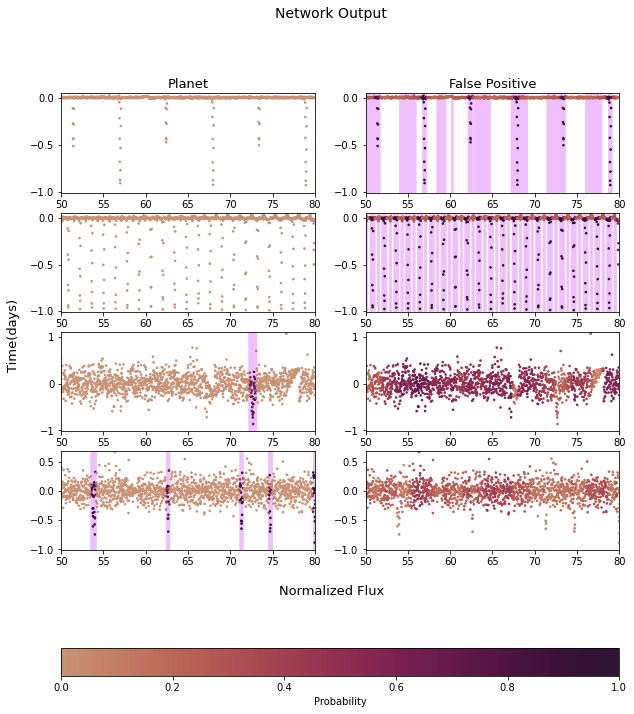

In [100]:
#plot probability spaces
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
Xtest = np.asarray(Xtest)
con = 29.4/1440
xax = np.arange(0,4000)
nmp = cm.get_cmap('twilight_shifted', 256)
nnmp = ListedColormap(nmp(np.linspace(0.65,1, 256)))#
fig,ax=plt.subplots(4,2,figsize=(10,12))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output', size=14)
#ar=np.random.randint(len(Xtest),size=10)
ar=[6,19,22,43]
ax[0][0].set_title('Planet', size=13)
ax[0][1].set_title('False Positive', size=13)
for i in range(0,4):
    pcounts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in Ytest[ar[i],:,:]])
    ppl = np.where(pcounts==0)[0]
    pfps = np.where(pcounts==1)[0]
    mn = min(Xtestf[ar[i]])
    mx = max(Xtestf[ar[i]])
    if(len(ppl)>0): ax[i][0].vlines(x=con*xax[ppl],ymin=2*mn, ymax=2*mx, alpha=0.5, color='#F0C0FE', zorder=0)
    if(len(pfps)>0): ax[i][1].vlines(x=con*xax[pfps],ymin=2*mn, ymax=2*mx, alpha=0.5, color='#F0C0FE', zorder=0)
    #m = min(Xtestf)
    

    ax[i][0].scatter(con*xax,Xtestf[ar[i]],c=pred_op[ar[i],:,0],cmap=nnmp,ls='None',marker='.',s=10,label='data',
        vmin=0, vmax=1, zorder=2)
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='yellow',ls='None',marker='.',label='bkg')

    im = ax[i][1].scatter(con*xax,Xtestf[ar[i],:],c=pred_op[ar[i],:,1],cmap=nnmp,ls='None',marker='.',
        s=10,label='data', vmin=0, vmax=1, zorder=2)

    ax[i][0].set_ylim(mn*1.01,mx*1.01)
    ax[i][1].set_ylim(mn*1.01,mx*1.01)
    ax[i][0].set_xlim(50,80)
    ax[i][1].set_xlim(50,80)

#ax[3][0].set_xlabel('Time', size=12)
fig.text(0.5, 0.3, 'Normalized Flux', ha='center', size=13)
fig.text(0.05, 0.6, 'Time(days)', va='center', rotation='vertical', size=13)
#ax[3][1].set_xlabel('Time', size=12)
plt.colorbar(im, ax=ax.ravel().tolist(),label="Probability", orientation="horizontal")
#plt.colorbar()
#plt.savefig('pap_network_op.png')

In [9]:
n = tf.keras.metrics.MeanIoU(num_classes=3)
#tpred=[[[max(x[0], x[1]), x[2]] for x in el] for el in pred_op]
#ttest=[[[max(x[0], x[1]), x[2]] for x in el] for el in Ytest]
n.update_state(np.around(Ytest[:300,:,:]), np.around(pred_op[:300,:,:]))
n.result().numpy()

0.6264819

In [9]:

Ytrainpred=convNN.predict(-Xtrainf)
Yvalpred=convNN.predict(-Xvalf)

In [19]:
lab_test = corr_v2(Ltest, pred_op, Ytest)
lab_train = corr_v2(Ltrain, Ytrainpred,Ytrain)
lab_val = corr_v2(Lval, Yvalpred, Yval)

mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
[[0.28258706 0.06666667]
 [0.10845771 0.54228856]]
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
[[0.27000497 0.0805169 ]
 [0.10623757 0.54324056]]
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
mult
[[0.26926927 0.08008008]
 [0.1021021  0.54854855]]


In [20]:
print(len(lab_test), len(Ytest))

1005 1005


In [21]:
net=np.asarray([[TestID[i],lab_test[i]] for i in range(len(lab_test))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_test_2',net,['id','pred_label'],['b','ar']
    ,['string','bool'])

net=np.asarray([[TrainID[i],lab_train[i]] for i in range(len(lab_train))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_train_2',net,['id','pred_label'],['b','ar']
    ,['string','bool'])

net=np.asarray([[ValID[i],lab_val[i]] for i in range(len(lab_val))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_val_2',net,['id','pred_label'],['b','ar']
    ,['string','bool'])

Wrote 1005 elements to TFRecord
Wrote 8048 elements to TFRecord
Wrote 999 elements to TFRecord


999

In [115]:
dice_coeff(Ytest, pred_op)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6309306>

In [5]:
#pixel accuracy ratio
ptest=[np.argmax(np.array([el[0],el[1],el[2]])) for el in np.reshape(pred_op,(len(pred_op)*4000,3))]
ppred=[np.argmax(el) for el in np.reshape(Ytest,(len(Ytest)*4000,3))]

cm=confusion_matrix(ptest, ppred)
print(cm/cm.sum())
print((cm[0,0]+cm[1,1]+cm[2,2])/cm.sum())

NameError: name 'pred_op' is not defined

In [6]:
#accuracy in transit detection and classification

def prec_rec_detect(thres):
    cm=[0,0]
    cm2=[0,0]
    tot =0
    tot2=0
    for i in range(len(pred_op)):
        pl = pred_op[i,:,0] + pred_op[i,:,1]
        #hpl = np.mean(pl)+thres*np.std(pl)
        #hpl2 = np.mean(pl)+2*thres*np.std(pl)
        hpl = thres
        xpl= Ytest[i,:,0] + Ytest[i,:,1]
        plp, _ = find_peaks(pl, height=hpl,distance=5)
        xplp, _ = find_peaks(xpl, height=0.5,distance=5)
        tot += len(plp)
        tot2 += len(xplp)
        for el in plp:
            if(xpl[el]>0): cm[0]+=1
            else: cm[1]+=1
        for el in xplp:
            if(pl[el]<hpl): cm2[1]+=1
            else: cm2[0]+=1

    return(cm[0]/tot, cm2[0]/tot)


   


In [112]:
#precision and recall in transit detection
prec = []
rec = []
for thr in np.linspace(0,5,5):
    p, r =prec_rec_detect(thr)
    prec.append(p)
    rec.append(r)


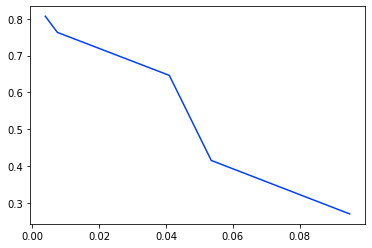

In [113]:
plt.plot(rec, prec)

plt.show()

In [73]:
maxarr_pred = [[ np.argmax(np.asarray([x[0],x[1],x[2]])) for x in el] for el in pred_op]
maxarr_predpl  =[[x==0 for x in el] for el in maxarr_pred]
maxarr_predfps  =[[x==1 for x in el] for el in maxarr_pred]

corrects=np.asarray([[0,0],[0,0]])
newc = 0
newinc = 0
for i in range(0,len(pred_op)):
    tick = 0
    ntick = 0
    plp, _ = find_peaks(maxarr_predpl[i], height=0.0,distance=20) 
    for m in plp:
        if(Ytest[i,m,0]>0.5): 
            corrects[0,0]+=1
            tick+=1
        if(Ytest[i,m,1]>0.5): 
            corrects[1,0]+=1
            ntick+=1
        #if(Ytrain[i,m,2]>0.5): corrects[2,0]+=1
        #else: corrects[2,0]+=1
    fpsp, _ = find_peaks(maxarr_predfps[i], height=0.0,distance=20)
    for m in fpsp:
        if(Ytest[i,m,1]>0.5): 
            corrects[1,1]+=1
            tick+=1
        if(Ytest[i,m,0]>0.5): 
            corrects[0,1]+=1
            ntick+=1
        #if(Ytrain[i,m,2]>0.1): corrects[0,2]+=1
        #else: corrects[0,2]+=1
    if(tick>ntick): newc+=1
    else: newinc+=1

print(corrects/corrects.sum())
print(newinc,newc, newinc/(newc+newinc))
print((corrects[0,0]+corrects[1,1])/corrects.sum())

[[0.15784002 0.08478198]
 [0.05486572 0.70251227]]
771 1062 0.4206219312602291
0.8603522956973723


In [6]:
convNN = keras.models.load_model('fin_joint.h5',custom_objects={'focal_dice_loss': focal_dice_loss, 'dice_coeff':dice_coeff})

In [27]:
#search for planet signatures, and anomalies and associated stuff
# read transit sig... make lomb scargle... right now, predict and redirect NN to the ones which promise best results
entries = os.listdir('../../processed_directories/full_lcs_all/')
ct=0
for el in entries:
    input,mask, counts, tdur, tperiod, tdepth = gc.read_tfr_record('../../processed_directories/full_lcs_all/'+el,
        ['input','mask','counts','tdur','tperiod','tdepth'],['ar','ar','ar','ar','ar','ar'],
        [tf.float32,tf.bool, tf.int8,tf.float16,tf.float16,tf.float16])
    tdur = np.array(tdur)
    tperiod = np.array(tperiod)
    tdepth = np.array(tdepth)
    input = np.asarray(input)
    if(tdur.shape[1] and tperiod.shape[1] and tdepth.shape[1]):
        ct+=1
        continue
    else:
        #print(tdur.shape, tperiod.shape, tdepth.shape)
        print(tdur)
        maskf=np.asarray(mask).reshape(len(input),4000,3)
        mid = np.median(input)
        mn = min(input.reshape(-1))
        try: inputf=np.asarray([(row-mid)/(-mn+mid) for row in input])
        except: 
            print('norm error',el)
            continue
        pred_mask = convNN.predict(-inputf)
        valp = [np.corrcoef(maskf[i,:,1],pred_mask[i,:,0])[0][1] if(np.any(maskf[i,:,1])>0) else 0 for i in range(0,len(inputf))]
        valf = [np.corrcoef(maskf[i,:,0],pred_mask[i,:,1])[0][1] if(np.any(maskf[i,:,0])>0) else 0 for i in range(0,len(inputf))]
        print(max(valp), max(valf))
        if(max(valp)> 0.5 or max(valf)>0.5):
            pred_mask = pred_mask.reshape(len(input), 12000)
            net = np.asarray([[input[i],mask[i],pred_mask[i],counts[i],tdur[i],tperiod[i],tdepth[i], valp[i], valf[i]] 
                for i in range(0,len(counts))],dtype='object')
            gc.write_tfr_record('../../processed_directories/full_lcs_ext_best_hyp/'+el,net,
            ['input','mask','pred_mask','counts','tdur','tperiod','tdepth','corr_pl','corr_fps'],
            ['ar','ar','ar','ar','ar','ar','ar','fl','fl'],
            ['float32','bool', 'float16','int8','float16','float16','float16','float16','float16'])
print(ct)



3047


In [28]:
# 3047 data points have been properly vetted in catalog... meaning their transit shapes and depths and all are defined well
# 1166 out of these have been predicted well by the neural network
# check how close the obtained values of periodicity and depth are to the actual predicted values.

def periodogram_and_freq(chunks, minp, maxp,ch=0, prec=10000):
    p = np.linspace(minp,maxp,prec)
    f = 2*np.pi /p
    tot = np.concatenate(chunks, axis=0)
    #thres = np.mean(tot)
    #tot = np.asarray([1 if(el>thres) else 0 for el in tot])
    #print(tot.shape, thres)
    #print(tot.shape)
    tot = [np.argmax(el) for el in tot]
    #print(len(tot))
    tot = np.asarray(np.asarray(tot)==ch)
    #print(tot)
    
    predp = lombscargle(np.arange(0,len(tot))*29.4/1440, tot,f, normalize=True)
    return(p, predp)

def color_a_peak_v2(input, el):
    req_p = int(el * 24 *60/29.4)
    phf = np.asarray([input[i:i+req_p] for i in range(0,len(input)-req_p,req_p)])
    phf = np.mean(phf, axis = 0)
    md = np.median(phf)
    std = np.std(phf)
    pts = np.asarray([i for i in range(len(phf)) if(phf[i]<md-0.7*std)])
    newpts = pts
    x=len(phf)
    while(x<68000):
        #print(x, len(pts))
        #print(len(pts+x*np.ones(len(pts))))
        newpts = np.concatenate([newpts,np.asarray(pts+x*np.ones(len(pts)),dtype='int')])
        x+=len(phf)
    #print(newpts)
    newpts = [el for el in newpts if el<68000] 
    return(newpts)

def what_the_peak(per, predp, ip, thres=1):
    newp=[]
    h = np.median(predp)+thres*np.std(predp)
    totip = np.concatenate(ip, axis=0)

    plp, _ = find_peaks(np.asarray(predp), height=h, distance=40)
    peakf = per[plp]
    #print(peakf)
    peakinfo = np.asarray([predp[plp],per[plp]])
    sortedArr = peakinfo [ :, peakinfo[0].argsort()]
    mn = np.mean(totip)
    #print(sortedArr)
    other = np.arange(0,len(totip),1)
    for p in np.flip(np.asarray(sortedArr[1])):
        #print(p)
        mask = color_a_peak_v2(totip, p)
        nother = np.setdiff1d(other,mask)
        #tmn = np.mean(totip[other])
        #print(p,len(other),len(nother),(len(other)-len(nother))/len(mask))
        if((len(other)-len(nother))/len(mask) > 0.15):
            newp.append(p)
            other = nother
        #print(mn, tmn)
        #if(tmn>mn): 
        #    mn = tmn
        #    newp.append(p)
        #else: continue
    return(newp)
    #choose good ones.

def plot_a_map(input, map):
    totip = np.concatenate(input)
    totop = np.concatenate(map, axis=0)

    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in totop])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    bkg=np.where(counts==2)[0]

    m=min(totip)
    plt.figure(figsize=(10,5))
    plt.title('Total Segmentation Map')
    plt.xlabel('time (days)')
    plt.ylabel('flux')
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,0])
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,1])
    plt.plot(np.asarray(bkg)*29.4/1440,totip[bkg], color='#a4b3b6', marker='.', ls='none', label='bkg')
    plt.plot(np.asarray(fps)*29.4/1440,totip[fps], color='#44318d', marker='.', ls='none', label='fps')
    plt.plot(np.asarray(pl)*29.4/1440,totip[pl], color='#d83f87', marker='.', ls='none', label='pl')
    plt.legend()

In [43]:
#search for planet signatures, and anomalies and associated stuff
# read transit sig... make lomb scargle... right now, predict and redirect NN to the ones which promise best results

#start at 570 next time
entries = os.listdir('../../processed_directories/full_lcs_best_results/correlation_results')
for el in entries[10:800]:
    input,mask, pred_mask, counts, tdur, tperiod, tdepth, corr_pl, corr_fps = gc.read_tfr_record('../../processed_directories/full_lcs_best_results/correlation_results/'+el,
        ['input','mask','pred_mask','counts','tdur','tperiod','tdepth','corr_pl','corr_fps'],
        ['ar','ar','ar','ar','ar','ar','ar','fl','fl'],
        ['float32','bool', 'float16','int8','float16','float16','float16','float16','float16'])
    tdur = np.array(tdur)
    tperiod = np.array(tperiod)
    tdepth = np.array(tdepth)
    input = np.asarray(input)

    ch = int(max(np.asarray(corr_fps))>max(np.asarray(corr_pl)))
    #print(max(np.asarray(corr_fps)), max(np.asarray(corr_pl)), ch)

    mask=np.asarray(mask).reshape(len(input),4000,3)
    pred_mask = np.asarray(pred_mask).reshape(len(input),4000,3)
    
    p,predp = periodogram_and_freq (pred_mask, 10,70000*29.4*0.5/1440, 1-ch, prec = 3000)
    segmapp_sm, segmappredp_sm = periodogram_and_freq (pred_mask, 2*29.4/1440,10, 1-ch, prec = 3000)  
 
    try:
        newp2 = what_the_peak(segmapp_sm, segmappredp_sm, np.asarray(input), 0.5)
        newp1 = what_the_peak(p, predp, np.asarray(input), 0.2)
        newp = np.concatenate(np.asarray([newp1,newp2]))
    except: continue
 
    #print(newp, tperiod[0])

    net = np.asarray([[input[i],tdur[i],tperiod[i],tdepth[i],newp,p,predp,segmapp_sm, segmappredp_sm] 
        for i in range(0,len(counts))],dtype='object')
    gc.write_tfr_record('../../processed_directories/full_lcs_best_results/lomb_sc_results/'+el,net,
            ['input','tdur','tperiod','tdepth','pred_period','p_l','ls_l','p_sm','ls_m'],
            ['ar','ar','ar','ar','ar','ar','ar','ar','ar'],
            ['float32','float16','float16','float16','float16','float16','float16','float16','float16'])



(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3

C:\Users\Hp\AppData\Roaming\Python\Python39\site-packages\scipy\signal\spectral.py:153: RuntimeWarning: divide by zero encountered in double_scalars
  pgram *= 2 / np.dot(y, y)
C:\Users\Hp\AppData\Roaming\Python\Python39\site-packages\scipy\signal\spectral.py:153: RuntimeWarning: invalid value encountered in multiply
  pgram *= 2 / np.dot(y, y)


(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 elements to TFRecord
(68000, 3)
(68000, 3)
Wrote 17 

KeyboardInterrupt: 